# Step 1: Install Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Beta Schedule and Noise Schedule
Defines how much noise is added at each time step. It increases linearly over time starting with a small value and ending with a larger one.

In [2]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

T = 200
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Step 3: Forward Diffusion Process
Gradually adds Gaussian noise to the original image across many steps. The image becomes more and more noisy with each step.

In [3]:
def forward_diffusion_sample(x_0, t, noise=None):
    # Add noise to the image x_0 at timestep t
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise, noise

# Step 4: Neural Network (U Net or simple CNN)
A simple convolutional neural network that takes the noisy image and the time step and learns to predict the noise that was added.

In [4]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t):
        return self.net(x)

# Step 5: Training Loop
The model is trained using many noisy images to minimize the difference between the actual and predicted noise (mean squared error).

In [5]:
def apply_transform_numpy(X, transform):
    X = torch.from_numpy(X).float()
    X = X.view(-1, 1, 28, 28)  # MNIST shape
    if transform is not None:
        X = transform(X)
    return X

def get_data(
    source="torchvision",  # "torchvision" | "openml" | "csv"
    batch_size=128,
    csv_path="mnist_train.csv"
):
    if source == "torchvision":
        tv_transform = transforms.Compose([transforms.ToTensor(), lambda x: x * 2.0 - 1.0])
        dataset = MNIST(root="./data", train=True, download=True, transform=tv_transform)
    elif source == "openml":
        tensor_transform = lambda x: x * 2.0 - 1.0
        mnist = fetch_openml("mnist_784", version=1, as_frame=False)
        X = mnist["data"].astype(np.float32) / 255.0
        y = mnist["target"].astype(int)
        X = apply_transform_numpy(X, tensor_transform)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)
    elif source == "csv":
        tensor_transform = lambda x: x * 2.0 - 1.0
        df = pd.read_csv(csv_path)
        X = df.iloc[:, 1:].values.astype(np.float32) / 255.0
        y = df.iloc[:, 0].values
        X = apply_transform_numpy(X, tensor_transform)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)
    else:
        raise ValueError("source must be 'torchvision', 'openml', or 'csv'")
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def train(model, dataloader, optimizer, epochs=5):
    for epoch in range(epochs):
        for step, (x, _) in enumerate(dataloader):
            x = x.to(device)
            t = torch.randint(0, T, (x.shape[0],), device=device).long()
            x_noisy, noise = forward_diffusion_sample(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

# Step 6: Sampling (Reverse Process)
Starts from pure noise and uses the model to remove noise step by step generating a clean image at the end.

In [6]:
@torch.no_grad()
def sample(model, image_size, num_samples):
    model.eval()
    x = torch.randn((num_samples, 1, image_size, image_size), device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        beta = betas[t]
        noise = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise) + torch.sqrt(beta) * noise
    return x

# Step 7: Running the Model
It sets up the device initializes the model and optimizer, loads the data and starts training. After training it generates 16 sample images from noise and displays them in a 4×4 grid.

Epoch 0: Loss 0.1399
Epoch 1: Loss 0.1412
Epoch 2: Loss 0.0973
Epoch 3: Loss 0.1004
Epoch 4: Loss 0.0939
Epoch 5: Loss 0.1054
Epoch 6: Loss 0.0956
Epoch 7: Loss 0.1040
Epoch 8: Loss 0.1007
Epoch 9: Loss 0.0923
Epoch 10: Loss 0.1041
Epoch 11: Loss 0.0985
Epoch 12: Loss 0.0928
Epoch 13: Loss 0.0902
Epoch 14: Loss 0.0991
Epoch 15: Loss 0.0908
Epoch 16: Loss 0.1007
Epoch 17: Loss 0.0884
Epoch 18: Loss 0.0944
Epoch 19: Loss 0.0862


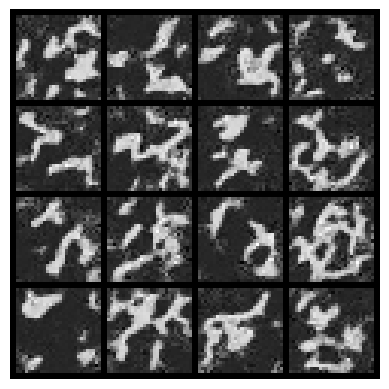

In [9]:
model = SimpleModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = get_data("csv")

train(model, dataloader, optimizer, epochs=20)

samples = sample(model, 28, 16)
grid = torchvision.utils.make_grid(samples.cpu(), nrow=4, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()